In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cycler, rcParams
from matplotlib.lines import Line2D
from model.calculate_features import CalculateFeatures
import model

In [2]:
pdf = pd.DataFrame
df = model.load_data('../../data/DATA_3_south.csv')
df.head()

,Magnitude,Latitude,Longitude,Depth,Datetime
0,3.9,16.8023,-94.9130,114.9,2017-01-01 00:54:31
1,3.9,15.2842,-93.1210,100.7,2017-01-01 04:10:39
2,3.9,17.4503,-94.9543,138.3,2017-01-01 04:23:51
3,3.9,16.4077,-93.7075,139.4,2017-01-01 04:26:01
4,4.1,16.7017,-98.8633,27.5,2017-01-01 08:49:23


In [3]:
len(df.index)
df.head()

,Magnitude,Latitude,Longitude,Depth,Datetime
0,3.9,16.8023,-94.9130,114.9,2017-01-01 00:54:31
1,3.9,15.2842,-93.1210,100.7,2017-01-01 04:10:39
2,3.9,17.4503,-94.9543,138.3,2017-01-01 04:23:51
3,3.9,16.4077,-93.7075,139.4,2017-01-01 04:26:01
4,4.1,16.7017,-98.8633,27.5,2017-01-01 08:49:23


In [4]:
df_model = CalculateFeatures(df, 50, trim_features=True,mag_threshold=5.0)

In [8]:
features =  df_model.features[model.C2_COLUMNS+model.C3_COLUMNS+model.F2_COLUMNS+model.F3_COLUMNS+model.F4_COLUMNS]

In [9]:

min_mag, max_mag = features.nextDMaxMag.agg(['min', 'max'])

df_groups_to_render = []


def applt_to_df_me_l_r5(aggregate):
    df_insight_me = pd.DataFrame()
    df_insight_l = pd.DataFrame()
    df_insight_r5 = pd.DataFrame()
    for mag in np.arange(min_mag, max_mag + .1, .1).round(1):
        mask = features.nextDMaxMag > mag
        df_insight_me[mag] = features[mask].apply(aggregate)
        df_insight_l[mag] = features[~mask].apply(aggregate)
        df_insight_r5[mag] = features[(features.nextDMaxMag > mag-.5)&(features.nextDMaxMag <= mag+.5)].apply(aggregate)
    return [df_insight_me, df_insight_l,df_insight_r5]


max = applt_to_df_me_l_r5(pdf.max)
min = applt_to_df_me_l_r5(pdf.min)
df_groups_to_render.append(["Minimum", *min])
df_groups_to_render.append(["Maximum", *max])
df_groups_to_render.append(["Mean", *applt_to_df_me_l_r5(pdf.mean)])
df_groups_to_render.append(["Variance", *applt_to_df_me_l_r5(pdf.var)])
df_groups_to_render.append(["diff max min", *list(map(lambda l:l[0]-l[1], zip(max, min)))])
df_groups_to_render.append(["mean diff", *applt_to_df_me_l_r5(lambda x: pdf.mean(pdf.diff(x)))])
df_groups_to_render.append(["max diff", *applt_to_df_me_l_r5(lambda x: pdf.max(pdf.diff(x)))])
df_groups_to_render.append(["min diff", *applt_to_df_me_l_r5(lambda x: pdf.min(pdf.diff(x)))])

In [10]:
def plot_relevant_features(df_groups_to_render):
    for group in df_groups_to_render:
        title = group[0]
        ax1 = group[1]
        ax2 = group[2]
        ax3 = group[3]
        nrows=len(ax1.T.columns)
        fig, axes = plt.subplots(nrows=nrows, ncols=1, constrained_layout=True)
        fig.suptitle(title, fontsize=20)
        fig.set_size_inches(10, 34)
        CMAP_1 = plt.cm.get_cmap("Set1")
        rcParams['axes.prop_cycle'] = cycler(color=CMAP_1(np.linspace(0, 1, nrows)))
        custom_lines = [Line2D([0], [0], color=CMAP_1(0), lw=4),
                        Line2D([0], [0], color=CMAP_1(1), lw=4),
                        Line2D([0], [0], color=CMAP_1(2), lw=4)
                        ]

        fig.legend(custom_lines, ['next14dMaxMag <= mag', 'next14dMaxMag > mag','next14dMaxMag = mag±.5',], loc=(.4, .97))
        for i, column in enumerate(ax1.T.columns):
            if i == nrows - 1:
                ax1.T[column].plot(ax=axes[i], kind="line", label=str(i), title=column,
                                   xticks=ax1.columns[::2], color=CMAP_1(1))
                ax2.T[column].plot(ax=axes[i], label=str(i), kind="line", color=CMAP_1(0))
                ax3.T[column].plot(ax=axes[i], label=str(i), kind="line", color=CMAP_1(2))
            elif i == 0:
                ax1.T[column].plot(ax=axes[i], kind="line", label=str(i), title=column,
                                   xticks=ax1.columns[::2], color=CMAP_1(1))
                ax2.T[column].plot(ax=axes[i], label=str(i), kind="line", color=CMAP_1(0))
                ax3.T[column].plot(ax=axes[i], label=str(i), kind="line", color=CMAP_1(2))
                axes[i].xaxis.set_ticks_position('top')
            else:
                ax1.T[column].plot(ax=axes[i], kind="line", title=column, color=CMAP_1(1))
                ax2.T[column].plot(ax=axes[i], kind="line", color=CMAP_1(0))
                ax3.T[column].plot(ax=axes[i], label=str(i), kind="line", color=CMAP_1(2))
                axes[i].tick_params(
                    axis='x',  # changes apply to the x-axis
                    which='both',  # both major and minor ticks are affected
                    bottom=False,  # ticks along the bottom edge are off
                    top=False,  # ticks along the top edge are off
                    labelbottom=False)  # labels along the bottom edge are off
                plt.rcParams['axes.titley'] = 1.0  # y is in axes-relative coordinates.
                plt.rcParams['axes.titlepad'] = -14  # pad is in points...
        plt.show()
        plt.clf()


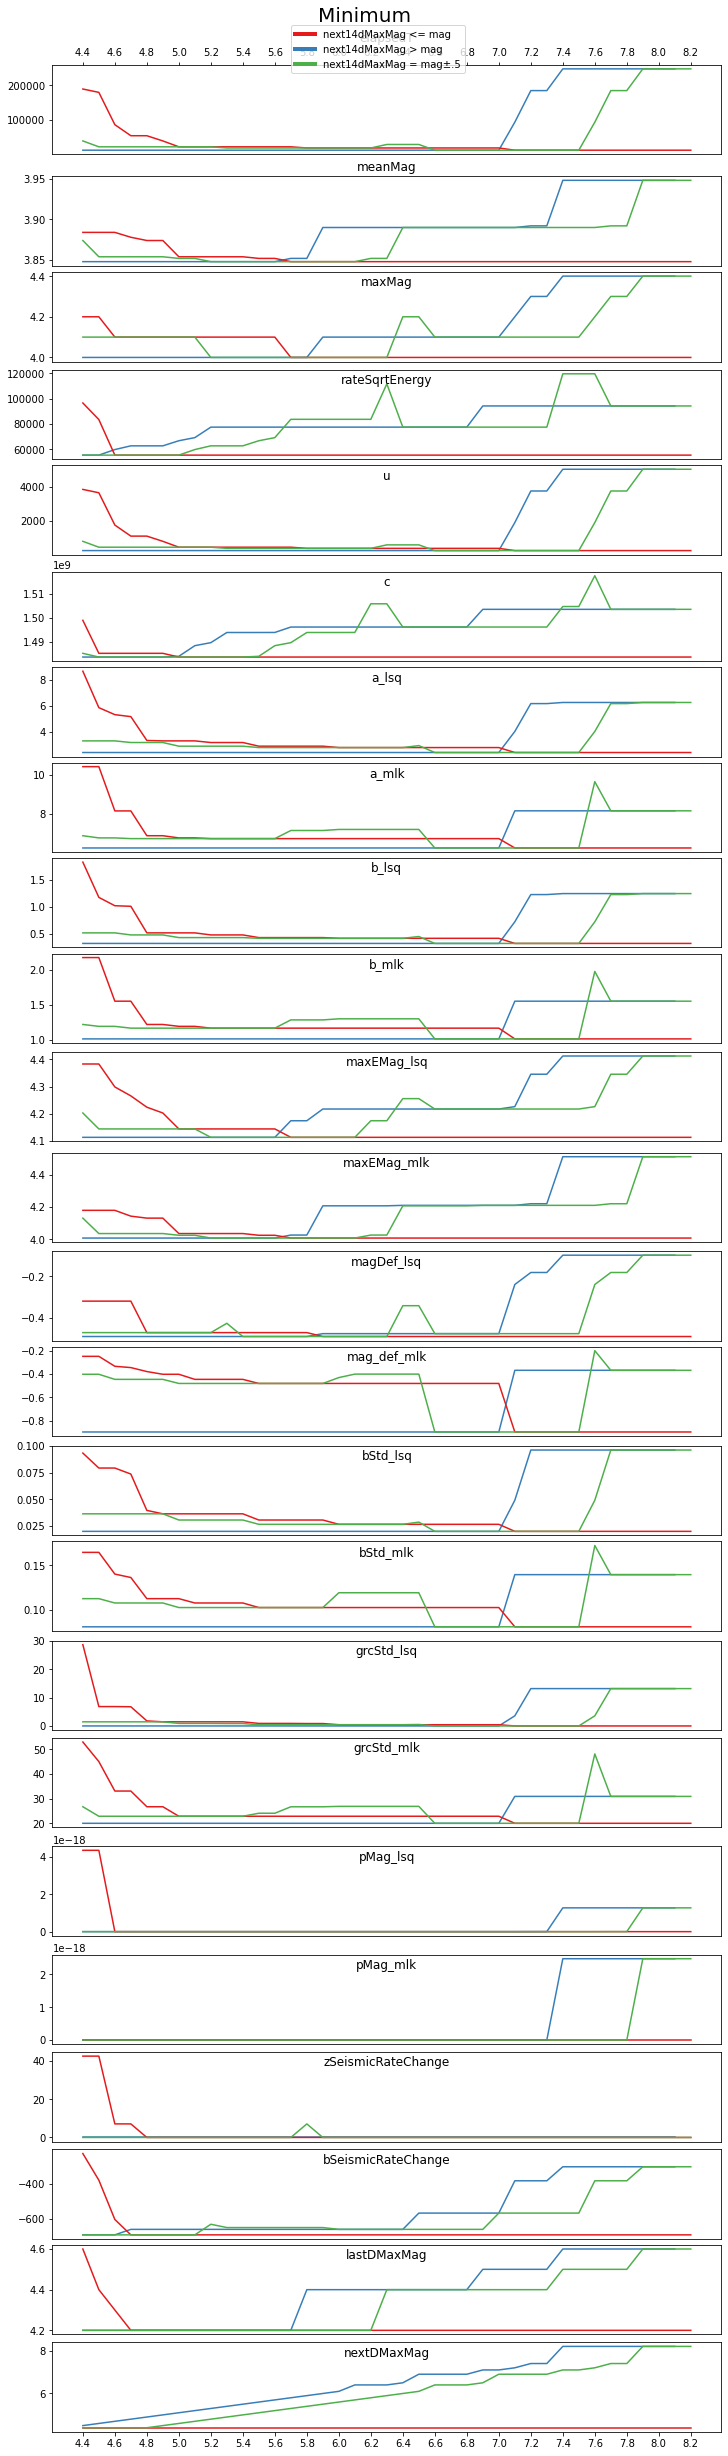

<Figure size 432x288 with 0 Axes>

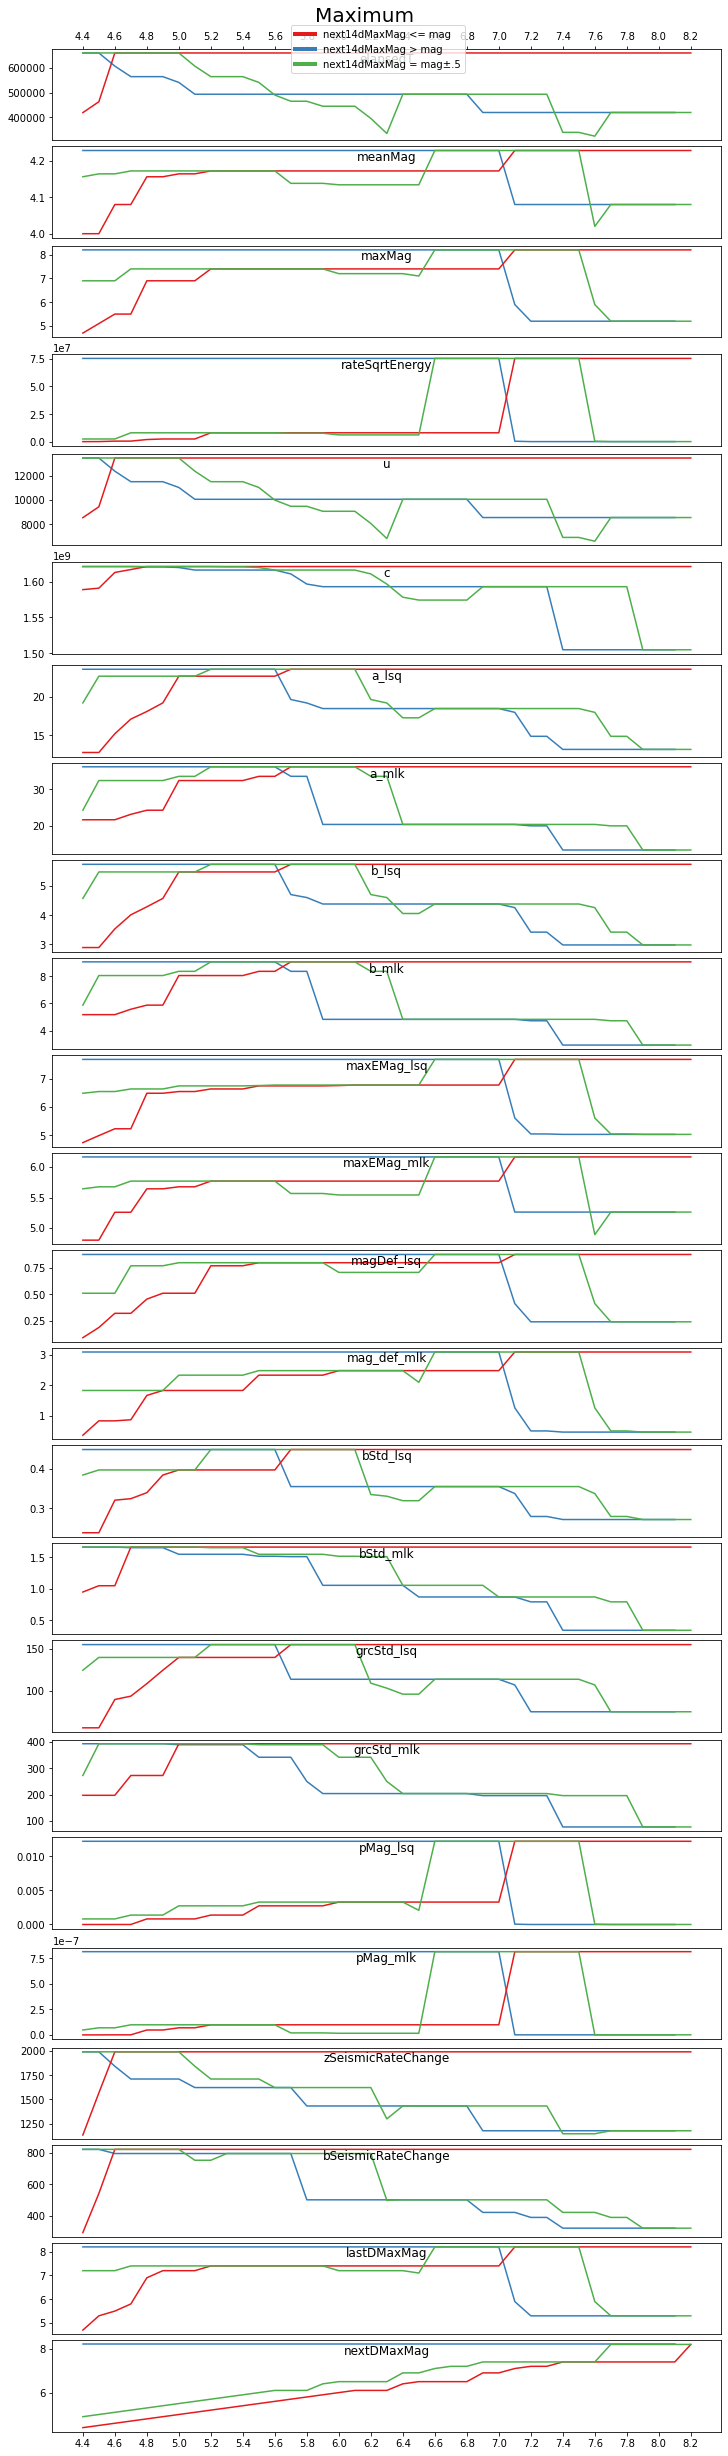

<Figure size 432x288 with 0 Axes>

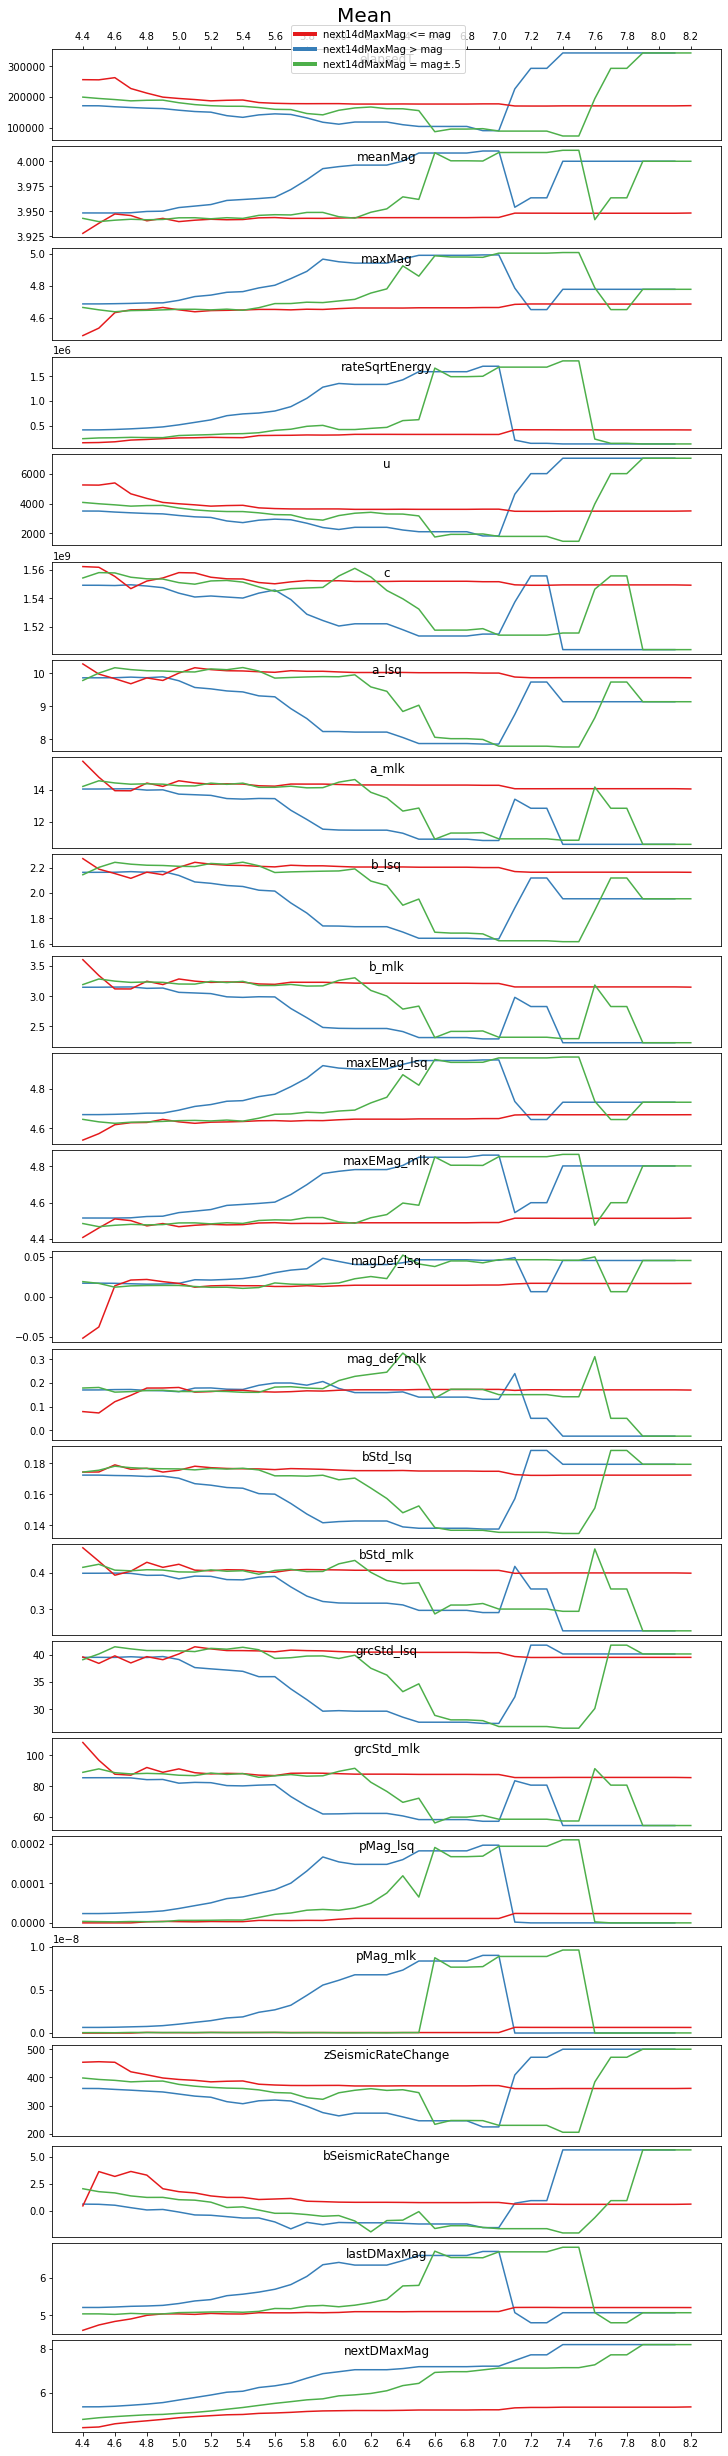

<Figure size 432x288 with 0 Axes>

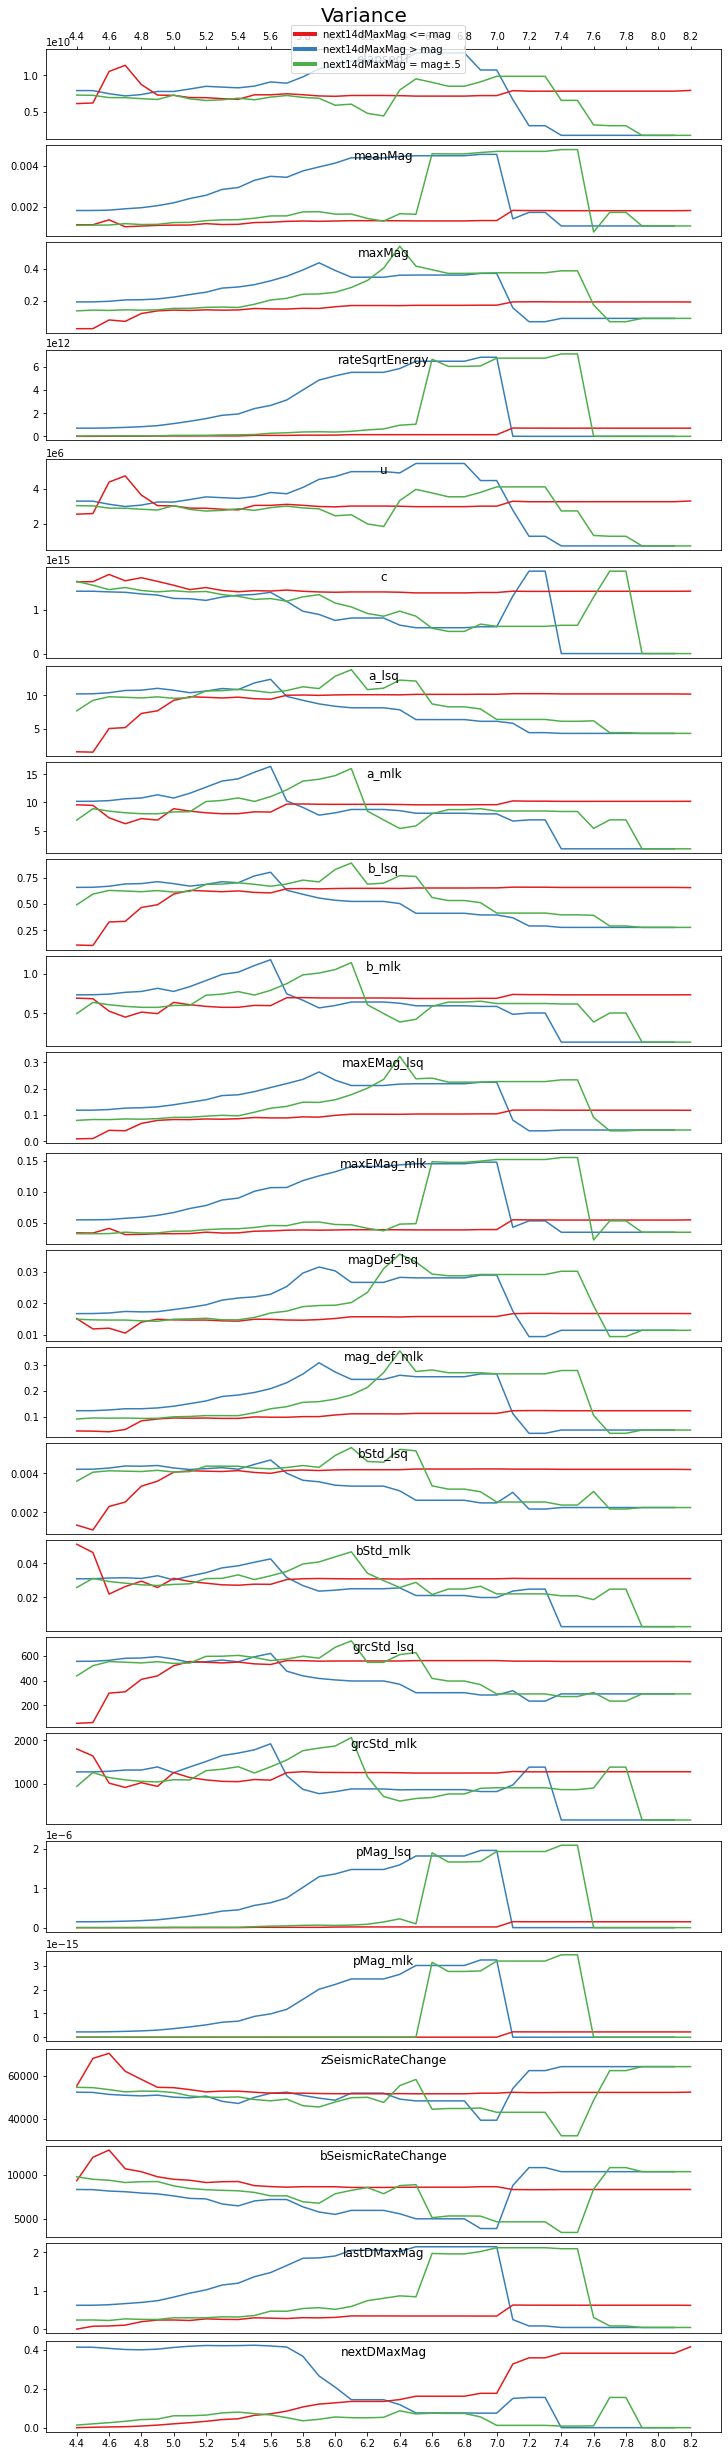

<Figure size 432x288 with 0 Axes>

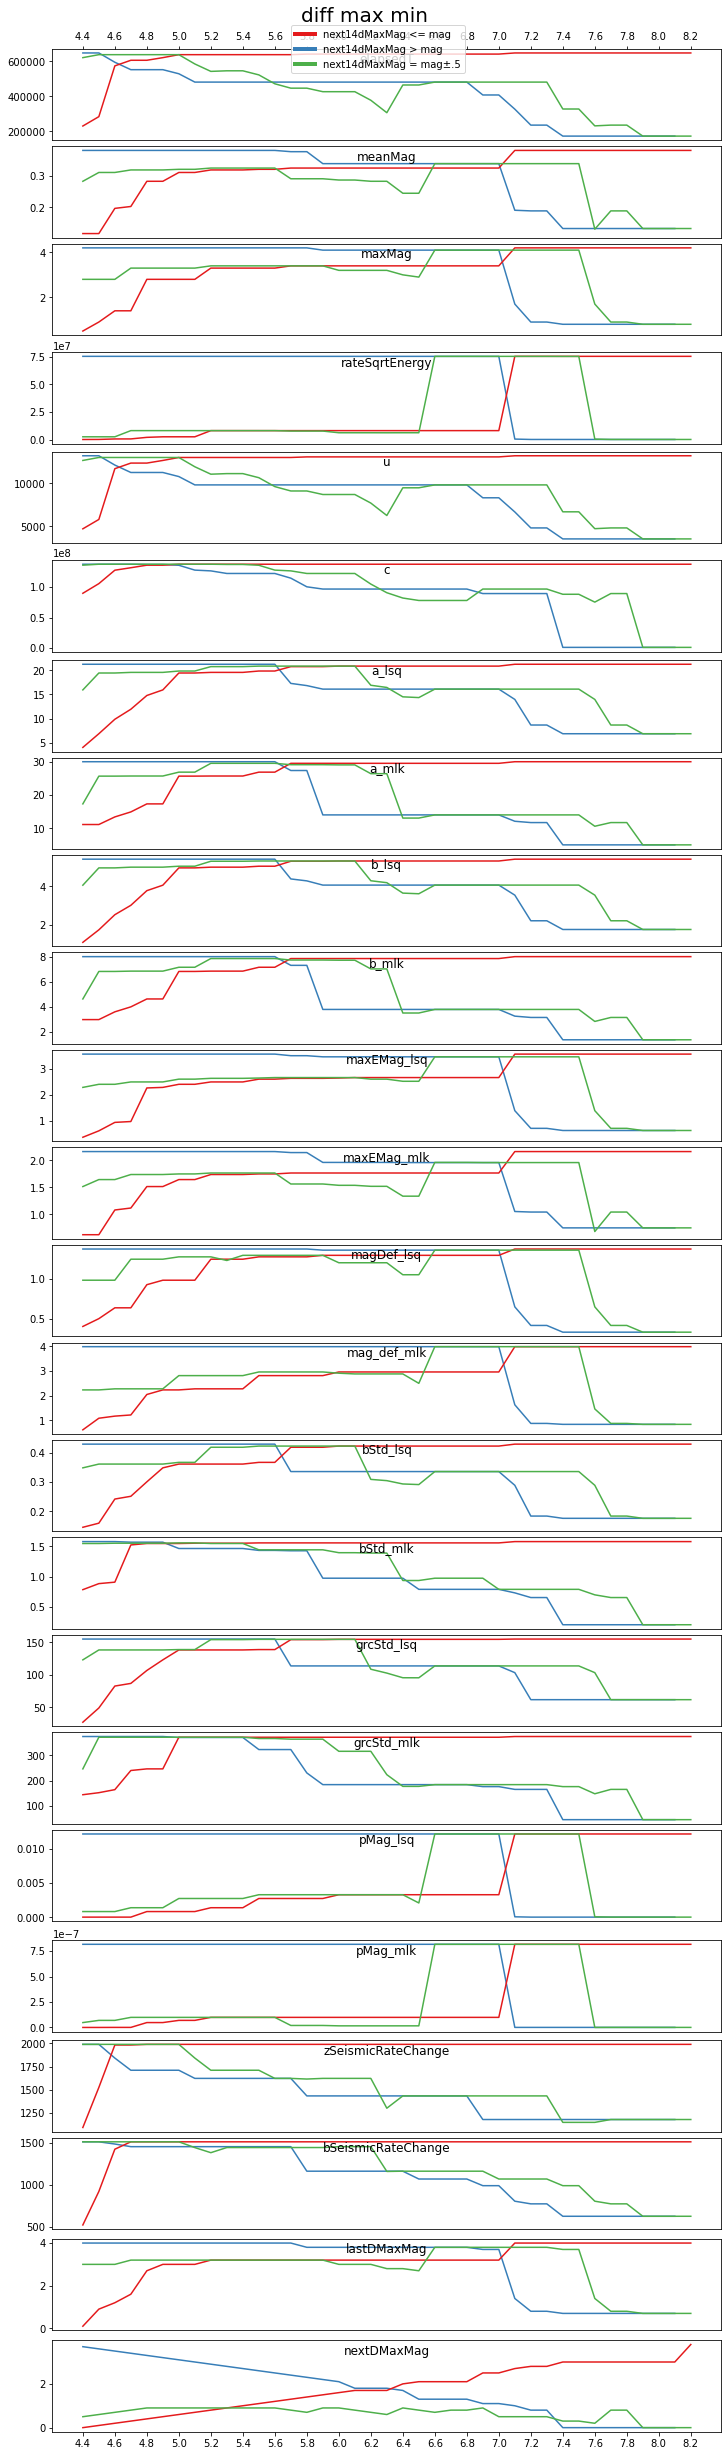

<Figure size 432x288 with 0 Axes>

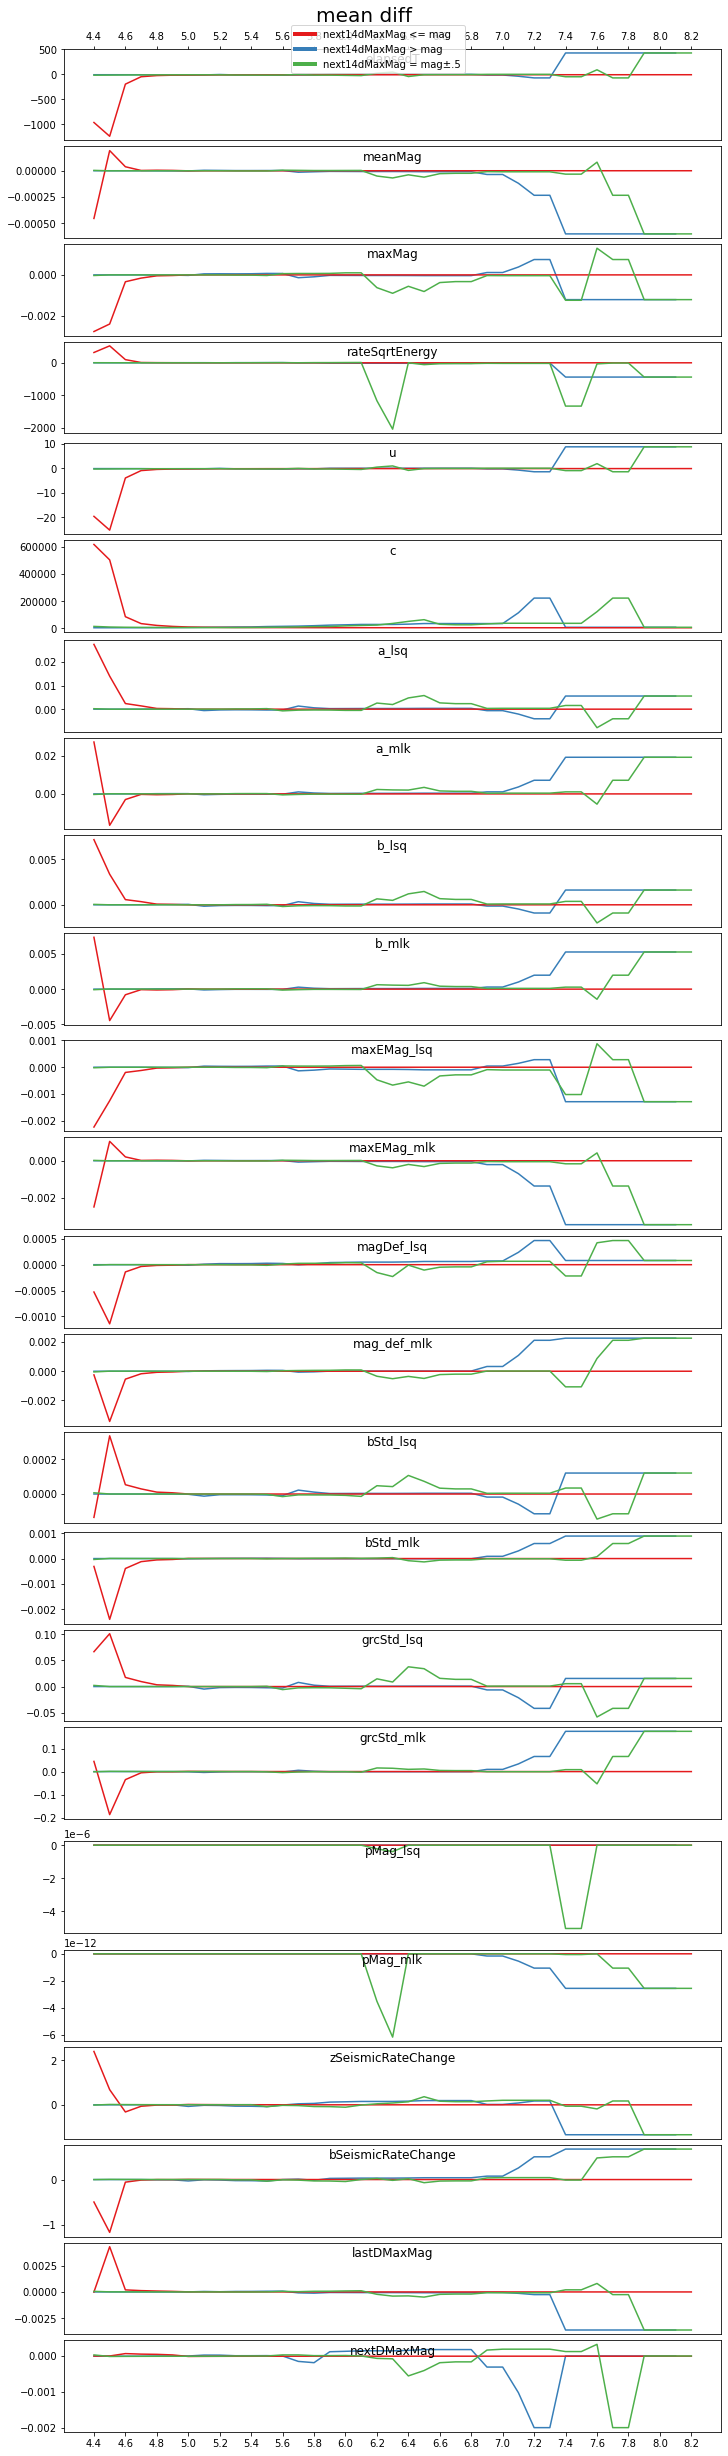

<Figure size 432x288 with 0 Axes>

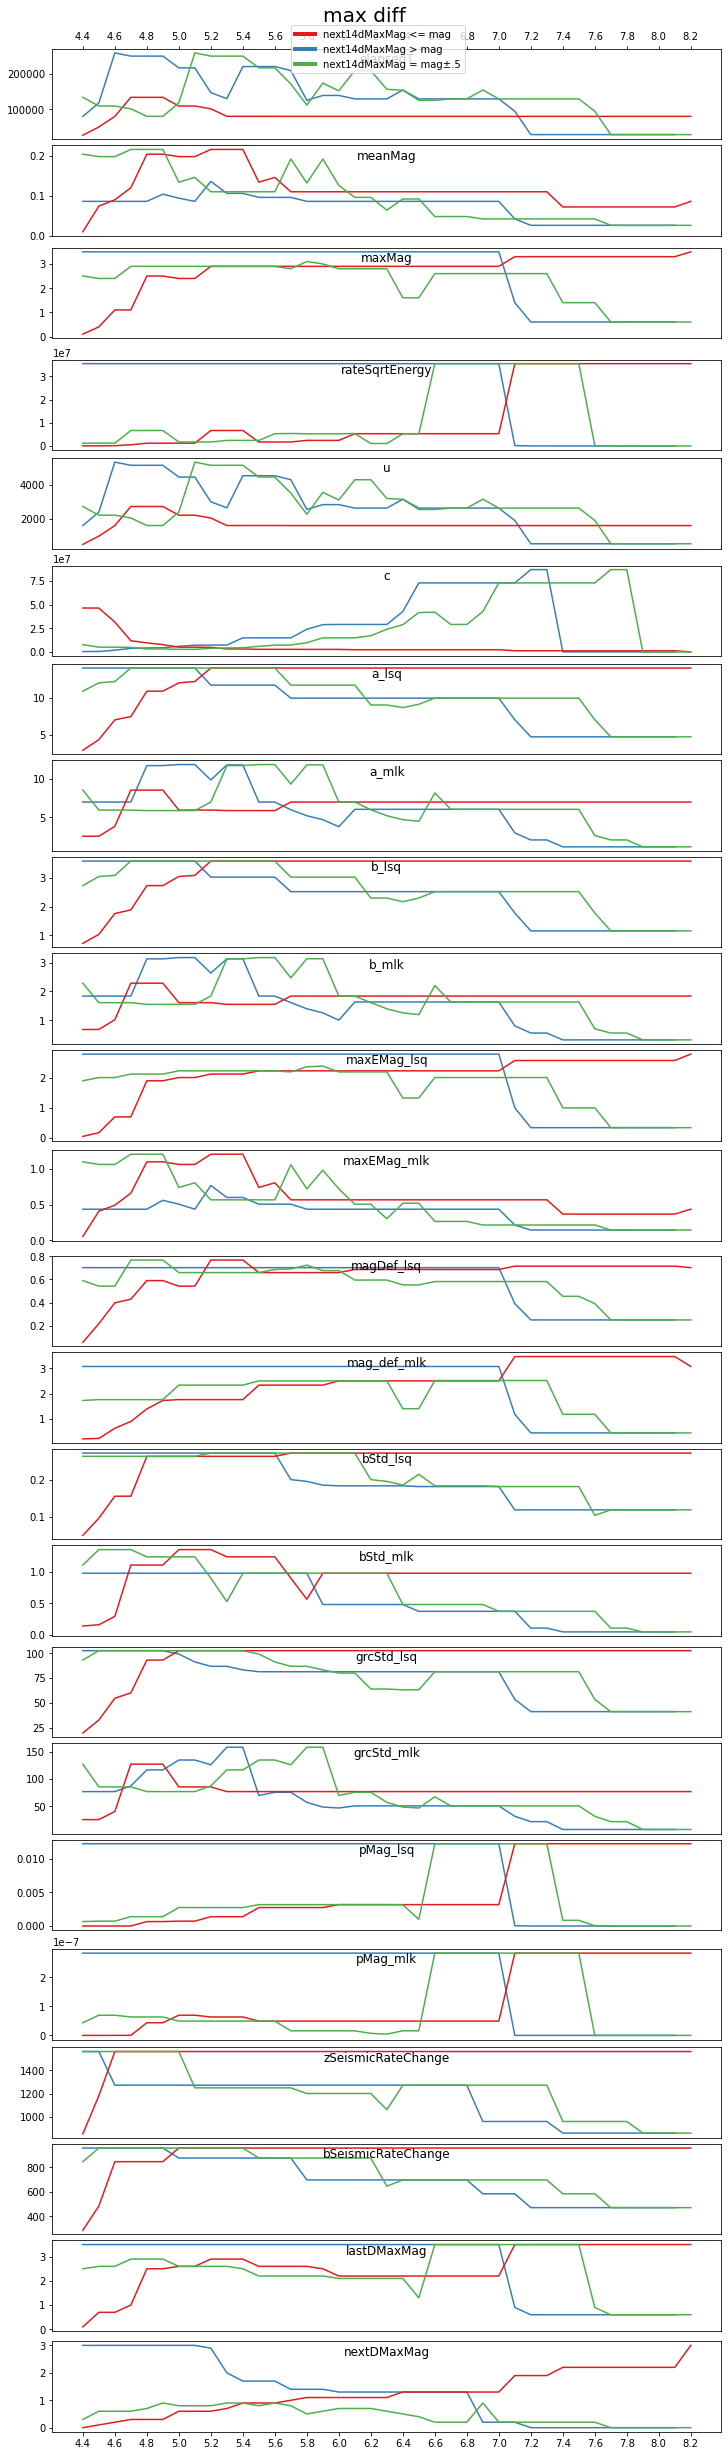

<Figure size 432x288 with 0 Axes>

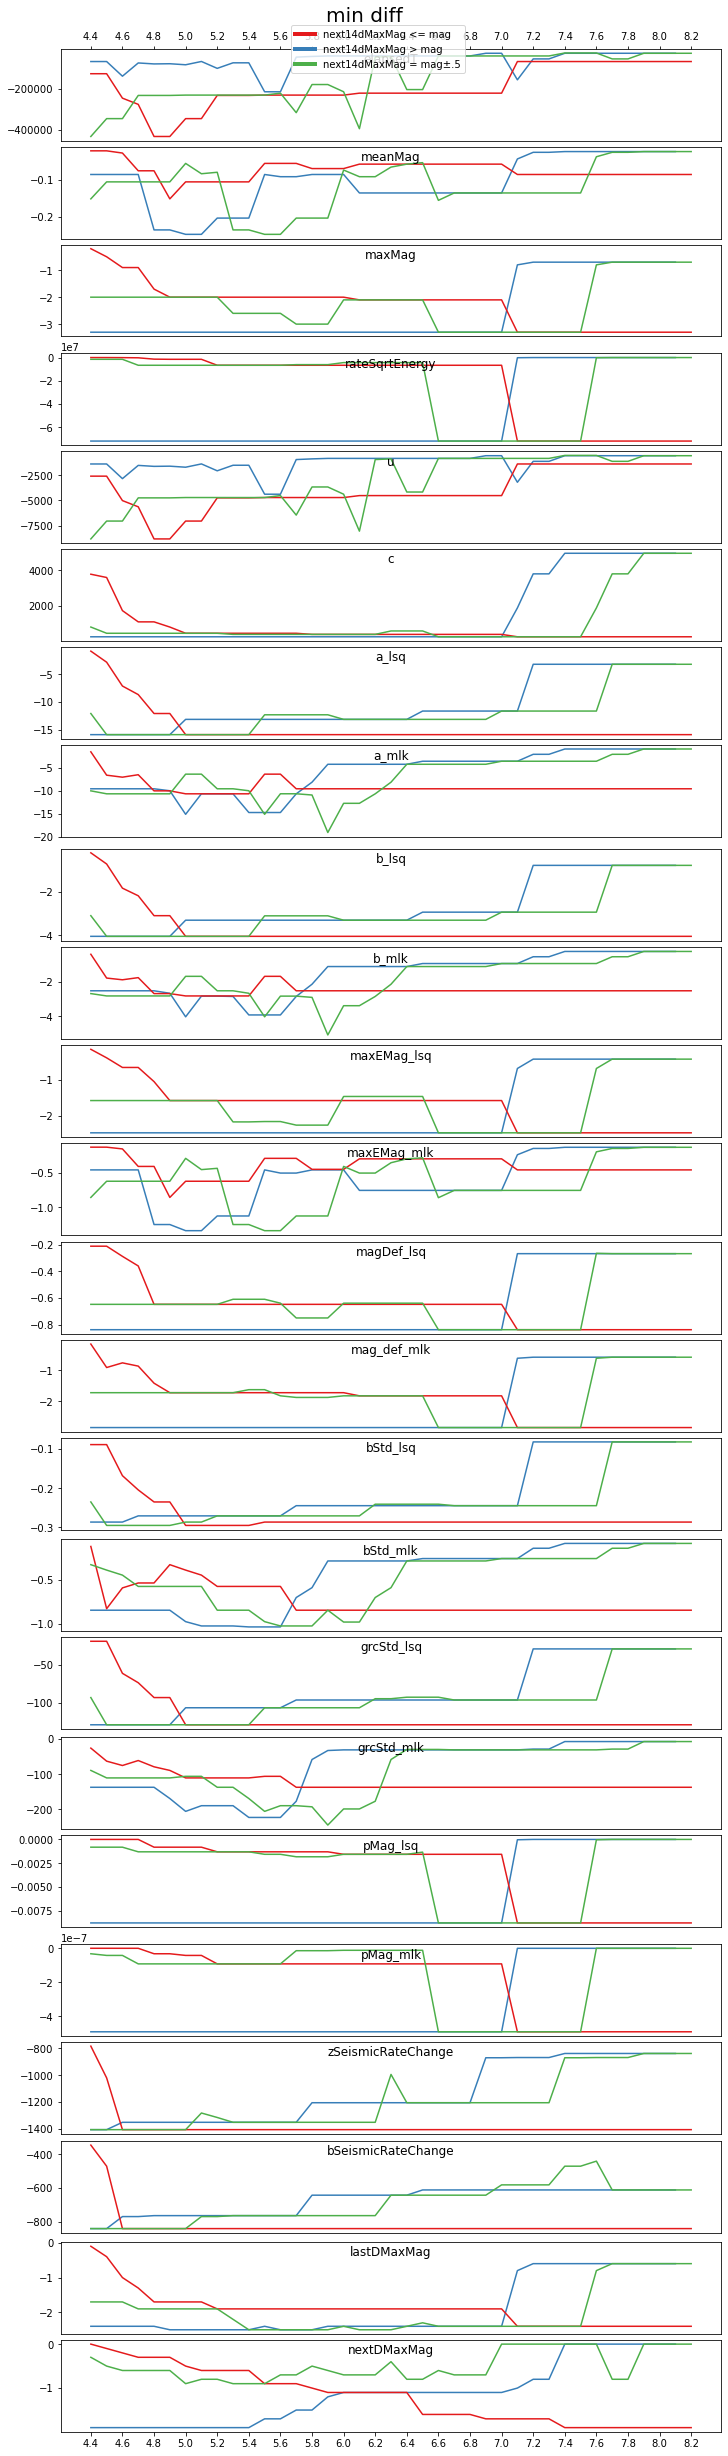

<Figure size 432x288 with 0 Axes>

In [11]:
plot_relevant_features(df_groups_to_render)